In [1]:
!pip install tensorflow numpy matplotlib scikit-learn seaborn

In [40]:
# imports and initial checks.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model # Ensure Model is imported
from tensorflow.keras.layers import Input, concatenate # Ensure Input and concatenate are imported
from tensorflow.keras.applications import ResNet50V2
# from tensorflow.keras.preprocessing.image import ImageDataGenerator # بديل إذا لم تستخدم image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
import os
import shutil # لاستخدامها في نسخ الملفات
import zipfile
from sklearn.metrics import classification_report, confusion_matrix, f1_score # لاستخدام f1_score في التقييم
import seaborn as sns

import kagglehub


# طباعة إصدار TensorFlow للتأكد
print(f"TensorFlow Version: {tf.__version__}")

# Check for TPU availability
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print("TPU is available:", tpu.cluster_spec().as_dict())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print("TPU initialized successfully")
except ValueError:
    print("TPU is NOT AVAILABLE")
    print("Consider enabling TPU in Runtime > Change runtime type.")

# Optionally, check GPU for completeness
gpu_available = tf.config.list_physical_devices('GPU')
print("GPU is", "available" if gpu_available else "NOT AVAILABLE")
if gpu_available:
    print("GPU Devices:", gpu_available)

TensorFlow Version: 2.18.0
TPU is NOT AVAILABLE
Consider enabling TPU in Runtime > Change runtime type.
GPU is available
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# STEP 2, download CASIA 2.0 Dataset
print("Downloading CASIA 2.0 dataset from KaggleHub...")
downloaded_dataset_path = kagglehub.dataset_download("divg07/casia-20-image-tampering-detection-dataset")
print(f"Dataset files are located at: {downloaded_dataset_path}")


extracted_base_path = downloaded_dataset_path

print("\nContents of the downloaded dataset directory:")

os.system(f'ls -l {extracted_base_path}') # يعرض محتويات المستوى الأول

# --- ابحث عن المسارات الفعلية لمجلدي Au و Tp ---
original_authentic_dir = None
original_tampered_dir = None

print(f"\nSearching for 'Au' and 'Tp' directories within: {extracted_base_path}")
for root, dirs, files in os.walk(extracted_base_path):
    if 'Au' in dirs:
        temp_auth_dir = os.path.join(root, 'Au')
        # تحقق مما إذا كان المجلد يحتوي على ملفات صور (لتجنب المجلدات الفارغة أو الخاطئة)
        if any(f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.bmp')) for f in os.listdir(temp_auth_dir)):
            original_authentic_dir = temp_auth_dir
            print(f"Found Authentic (Au) images directory: {original_authentic_dir}")

    if 'Tp' in dirs:
        temp_tamp_dir = os.path.join(root, 'Tp')
        if any(f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.bmp')) for f in os.listdir(temp_tamp_dir)):
            original_tampered_dir = temp_tamp_dir
            print(f"Found Tampered (Tp) images directory: {original_tampered_dir}")


    if original_authentic_dir and original_tampered_dir:
         break # وجدنا المجلدين المطلوبين

# إذا لم يتم العثور على المجلدات مباشرة، قد تكون داخل مجلد آخر باسم مجموعة البيانات نفسها
if not original_authentic_dir or not original_tampered_dir:
    print("Initial search failed. Trying to look deeper if there's a common dataset name folder...")
    possible_dataset_folders = [d for d in os.listdir(extracted_base_path) if os.path.isdir(os.path.join(extracted_base_path, d))]
    if len(possible_dataset_folders) == 1: # إذا كان هناك مجلد واحد فقط بالداخل
        deeper_base_path = os.path.join(extracted_base_path, possible_dataset_folders[0])
        print(f"Searching again within deeper path: {deeper_base_path}")
        for root, dirs, files in os.walk(deeper_base_path):
            if 'Au' in dirs:
                temp_auth_dir = os.path.join(root, 'Au')
                if any(f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.bmp')) for f in os.listdir(temp_auth_dir)):
                    original_authentic_dir = temp_auth_dir
                    print(f"Found Authentic (Au) images directory: {original_authentic_dir}")
            if 'Tp' in dirs:
                temp_tamp_dir = os.path.join(root, 'Tp')
                if any(f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.bmp')) for f in os.listdir(temp_tamp_dir)):
                    original_tampered_dir = temp_tamp_dir
                    print(f"Found Tampered (Tp) images directory: {original_tampered_dir}")
            if original_authentic_dir and original_tampered_dir:
                break


if not original_authentic_dir or not original_tampered_dir:
    print("ERROR: Could not automatically find 'Au' and/or 'Tp' directories even after deeper search.")
    print(f"Please inspect the contents of '{extracted_base_path}' manually (e.g., using !ls -R '{extracted_base_path}' in a new cell) and set 'original_authentic_dir' and 'original_tampered_dir' paths correctly.")
else:
    print(f"\nAuthentic images will be sourced from: {original_authentic_dir}")
    print(f"Tampered images will be sourced from: {original_tampered_dir}")

    # --- إعداد مجلد جديد للبيانات بالهيكل المطلوب لـ TensorFlow ---
    prepared_data_dir = '/content/data_for_tf'
    if os.path.exists(prepared_data_dir):
        print(f"Cleaning up existing prepared data directory: {prepared_data_dir}")
        shutil.rmtree(prepared_data_dir)

    os.makedirs(os.path.join(prepared_data_dir, 'authentic'), exist_ok=True)
    os.makedirs(os.path.join(prepared_data_dir, 'forged'), exist_ok=True)

    target_authentic_dir = os.path.join(prepared_data_dir, 'authentic')
    target_forged_dir = os.path.join(prepared_data_dir, 'forged')

    def copy_files(src_dir, dest_dir, file_extensions=('.jpg', '.jpeg', '.png', '.tif', '.bmp')):
        if not os.path.exists(src_dir) or not os.path.isdir(src_dir): # التأكد أنه مجلد موجود
            print(f"Source directory {src_dir} not found or is not a directory!")
            return 0
        count = 0
        print(f"Copying from {src_dir} to {dest_dir}...")
        for filename in os.listdir(src_dir):
            if filename.lower().endswith(file_extensions):
                try:
                    shutil.copy(os.path.join(src_dir, filename), os.path.join(dest_dir, filename))
                    count += 1
                except Exception as e:
                    print(f"Could not copy {filename}: {e}")
        print(f"Copied {count} files from {src_dir} to {dest_dir}")
        return count

    print("\nCopying authentic images...")
    num_auth = copy_files(original_authentic_dir, target_authentic_dir)

    print("\nCopying tampered images...")
    num_forged = copy_files(original_tampered_dir, target_forged_dir)

    if num_auth > 0 and num_forged > 0:
        print("\nData preparation complete.")
        print(f"Total authentic images prepared: {num_auth}")
        print(f"Total forged images prepared: {num_forged}")
        if abs(num_auth - num_forged) > 0.1 * (num_auth + num_forged):
             print("WARNING: The dataset classes might be imbalanced.")
        DATA_DIR = prepared_data_dir # تحديث DATA_DIR ليشير إلى المجلد المجهز
    else:
        print("ERROR: No images were copied. Please check the paths and content of 'Au' and 'Tp' directories (original_authentic_dir, original_tampered_dir).")
        DATA_DIR = None

Dataset files are located at: /kaggle/input/casia-20-image-tampering-detection-dataset

Contents of the downloaded dataset directory:

Searching for 'Au' and 'Tp' directories within: /kaggle/input/casia-20-image-tampering-detection-dataset
Found Authentic (Au) images directory: /kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au
Found Tampered (Tp) images directory: /kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp

Authentic images will be sourced from: /kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au
Tampered images will be sourced from: /kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp

Copying authentic images...
Copying from /kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au to /content/data_for_tf/authentic...
Copied 7491 files from /kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au to /content/data_for_tf/authentic

Copying tampered images...
Copying from /kaggle/input/casia-20-ima

In [5]:
# 2.5 manual splitting of dataset
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split # لاستخدامها في التقسيم

SEED = 42

source_data_dir = '/content/data_for_tf' # هذا هو DATA_DIR السابق

# المسار الجديد الذي سننشئ فيه مجلدات التدريب والتحقق المقسمة
split_base_dir = '/content/train_val_split_manual'

# مسارات مجلدات الفئات الأصلية
original_authentic_files_dir = os.path.join(source_data_dir, 'authentic')
original_forged_files_dir = os.path.join(source_data_dir, 'forged')

# مسارات مجلدات التدريب والتحقق الجديدة
train_dir = os.path.join(split_base_dir, 'train')
validation_dir = os.path.join(split_base_dir, 'validation')

train_authentic_dir = os.path.join(train_dir, 'authentic')
train_forged_dir = os.path.join(train_dir, 'forged')
validation_authentic_dir = os.path.join(validation_dir, 'authentic')
validation_forged_dir = os.path.join(validation_dir, 'forged')

# نسبة التقسيم (نفس VALIDATION_SPLIT السابق)
val_split_ratio = 0.2 # 20% للتحقق، 80% للتدريب
random_seed_split = SEED # استخدام نفس SEED لضمان التكرارية

# حذف المجلدات القديمة إذا كانت موجودة لضمان بداية نظيفة
if os.path.exists(split_base_dir):
    print(f"Removing existing directory: {split_base_dir}")
    shutil.rmtree(split_base_dir)

# إنشاء المجلدات الجديدة
print(f"Creating new directory structure under: {split_base_dir}")
os.makedirs(train_authentic_dir, exist_ok=True)
os.makedirs(train_forged_dir, exist_ok=True)
os.makedirs(validation_authentic_dir, exist_ok=True)
os.makedirs(validation_forged_dir, exist_ok=True)

def split_and_copy_files(source_class_dir, train_class_dir, val_class_dir, split_ratio, seed):
    filenames = os.listdir(source_class_dir)
    # خلط أسماء الملفات لضمان عشوائية التقسيم
    np.random.seed(seed) # تعيين seed لـ numpy أيضًا قبل الخلط
    np.random.shuffle(filenames)

    # تقسيم أسماء الملفات
    train_files, val_files = train_test_split(filenames, test_size=split_ratio, random_state=seed, shuffle=True) # shuffle=True هنا ضروري لـ train_test_split

    print(f"Splitting {len(filenames)} files from {os.path.basename(source_class_dir)}: {len(train_files)} for training, {len(val_files)} for validation.")

    # نسخ ملفات التدريب
    for f_name in train_files:
        shutil.copy(os.path.join(source_class_dir, f_name), os.path.join(train_class_dir, f_name))

    # نسخ ملفات التحقق
    for f_name in val_files:
        shutil.copy(os.path.join(source_class_dir, f_name), os.path.join(val_class_dir, f_name))

    return len(train_files), len(val_files)

# تقسيم ونسخ ملفات الفئة 'authentic'
print("\nProcessing 'authentic' files...")
num_train_auth, num_val_auth = split_and_copy_files(original_authentic_files_dir, train_authentic_dir, validation_authentic_dir, val_split_ratio, random_seed_split)

# تقسيم ونسخ ملفات الفئة 'forged'
print("\nProcessing 'forged' files...")
num_train_forged, num_val_forged = split_and_copy_files(original_forged_files_dir, train_forged_dir, validation_forged_dir, val_split_ratio, random_seed_split)

print("\n--- Manual Data Split Summary ---")
print(f"Total 'authentic' for training: {num_train_auth}")
print(f"Total 'authentic' for validation: {num_val_auth}")
print(f"Total 'forged' for training: {num_train_forged}")
print(f"Total 'forged' for validation: {num_val_forged}")
print("----------------------------------")


NEW_TRAIN_DIR = train_dir
NEW_VALIDATION_DIR = validation_dir

Creating new directory structure under: /content/train_val_split_manual

Processing 'authentic' files...
Splitting 7491 files from authentic: 5992 for training, 1499 for validation.

Processing 'forged' files...
Splitting 5123 files from forged: 4098 for training, 1025 for validation.

--- Manual Data Split Summary ---
Total 'authentic' for training: 5992
Total 'authentic' for validation: 1499
Total 'forged' for training: 4098
Total 'forged' for validation: 1025
----------------------------------


In [6]:
# STEP 2.6 Convert TIF to PNG.
from PIL import Image
import os
import glob # لاستخدامه في البحث عن الملفات


if 'NEW_TRAIN_DIR' not in globals():
    print("ERROR: NEW_TRAIN_DIR not defined. Run Cell 2.5 first.")


conversion_train_dir = NEW_TRAIN_DIR if 'NEW_TRAIN_DIR' in globals() else '/content/train_val_split_manual/train'
conversion_validation_dir = NEW_VALIDATION_DIR if 'NEW_VALIDATION_DIR' in globals() else '/content/train_val_split_manual/validation'

folders_to_process = [
    os.path.join(conversion_train_dir, 'authentic'),
    os.path.join(conversion_train_dir, 'forged'),
    os.path.join(conversion_validation_dir, 'authentic'),
    os.path.join(conversion_validation_dir, 'forged')
]

converted_count = 0
deleted_tif_count = 0

print("\n--- Starting TIF to PNG Conversion ---")
for folder_path in folders_to_process:
    if not os.path.exists(folder_path):
        print(f"Warning: Folder not found, skipping: {folder_path}")
        continue

    print(f"Processing folder: {folder_path}")
    # استخدم glob للبحث عن ملفات .tif و .tiff بشكل غير حساس لحالة الأحرف
    tif_files = glob.glob(os.path.join(folder_path, '*.tif')) + \
                glob.glob(os.path.join(folder_path, '*.TIF')) + \
                glob.glob(os.path.join(folder_path, '*.tiff')) + \
                glob.glob(os.path.join(folder_path, '*.TIFF'))

    if not tif_files:
        print("No .tif/.tiff files found in this folder.")
        continue

    for tif_filepath in tif_files:
        try:
            # إنشاء اسم الملف الجديد بامتداد .png
            base_filename = os.path.splitext(os.path.basename(tif_filepath))[0]
            png_filepath = os.path.join(folder_path, base_filename + '.png')

            # فتح ملف TIF وتحويله وحفظه كـ PNG
            with Image.open(tif_filepath) as img:
                # التأكد من أن الصورة ليست بالفعل PNG لتجنب إعادة الحفظ غير الضروري إذا كان هناك خطأ في الامتداد
                if img.format != 'PNG':
                    img.save(png_filepath, 'PNG')
                    converted_count += 1

                    try:
                        os.remove(tif_filepath)
                        deleted_tif_count +=1
                    except Exception as e_del:
                        print(f"Could not delete original TIF file {tif_filepath}: {e_del}")
                elif tif_filepath != png_filepath: # إذا كان الامتداد TIF ولكن الصيغة PNG، احذف TIF إذا لم يتم حفظه كـ PNG جديد
                     try:
                        os.remove(tif_filepath)
                        deleted_tif_count +=1
                        print(f"Original TIF {tif_filepath} was already PNG format, removed TIF extension version.")
                     except Exception as e_del:
                        print(f"Could not delete original TIF file {tif_filepath} (already PNG format): {e_del}")

        except Exception as e:
            print(f"Error converting file {tif_filepath}: {e}")

print(f"\n--- Conversion Summary ---")
print(f"Total .tif/.tiff files converted to .png: {converted_count}")
print(f"Total original .tif/.tiff files deleted: {deleted_tif_count}")
print("--------------------------")

if converted_count == 0 and deleted_tif_count == 0:
    print("No TIF files were found or needed conversion in the specified folders.")


--- Starting TIF to PNG Conversion ---
Processing folder: /content/train_val_split_manual/train/authentic
No .tif/.tiff files found in this folder.
Processing folder: /content/train_val_split_manual/train/forged
Processing folder: /content/train_val_split_manual/validation/authentic
No .tif/.tiff files found in this folder.
Processing folder: /content/train_val_split_manual/validation/forged

--- Conversion Summary ---
Total .tif/.tiff files converted to .png: 3059
Total original .tif/.tiff files deleted: 3059
--------------------------


Using TRAIN_DIR: /content/train_val_split_manual/train
Using VALIDATION_DIR: /content/train_val_split_manual/validation
Creating new ELA directory structure under: /content/ela_dataset_prepared

--- Starting ELA Generation for all datasets (Quality=90, Scale=15) ---

Processing RGB images from: /content/train_val_split_manual/train/authentic
Saving ELA images to: /content/ela_dataset_prepared/train/authentic_ela
  Processed 200 images in authentic...
  Processed 400 images in authentic...
  Processed 600 images in authentic...
  Processed 800 images in authentic...
  Processed 1000 images in authentic...
  Processed 1200 images in authentic...
  Processed 1400 images in authentic...
  Processed 1600 images in authentic...
  Processed 1800 images in authentic...
  Processed 2000 images in authentic...
  Processed 2200 images in authentic...
  Processed 2400 images in authentic...
  Processed 2600 images in authentic...
  Processed 2800 images in authentic...
  Processed 3000 images in a

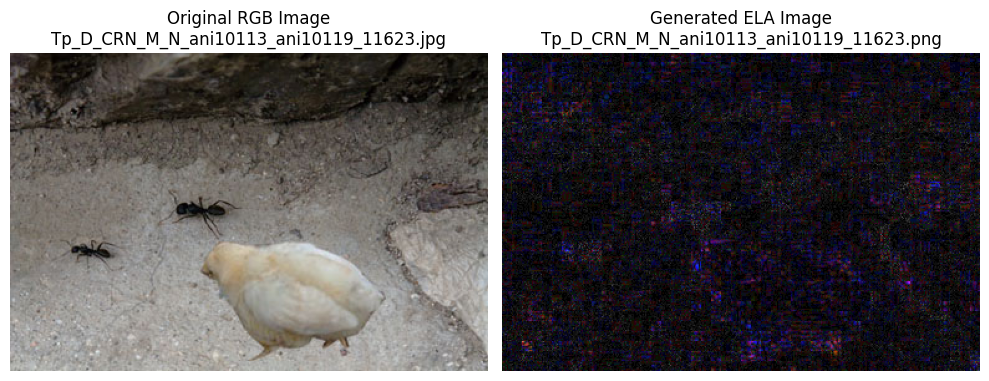

In [36]:
# STEP 2.7 Create ELA Dataset
import os
import shutil
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
import io

def generate_ela_image(image_path, quality=90, scale_factor=15):
    """
    Generates an Error Level Analysis (ELA) image for a given image path.
    """
    try:
        original_image = Image.open(image_path).convert('RGB')

        temp_buffer = io.BytesIO()
        original_image.save(temp_buffer, 'JPEG', quality=quality)
        temp_buffer.seek(0)
        resaved_image = Image.open(temp_buffer)

        ela_image = ImageChops.difference(original_image, resaved_image)


        ela_image_enhanced = ImageEnhance.Brightness(ela_image).enhance(scale_factor)

        temp_buffer.close()
        return ela_image_enhanced
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"An error occurred while generating ELA for {image_path}: {e}")
        return None

# تحقق من وجود المتغيرات TRAIN_DIR و VALIDATION_DIR
if 'TRAIN_DIR' not in globals() or 'VALIDATION_DIR' not in globals():
    print("ERROR: TRAIN_DIR or VALIDATION_DIR is not defined. Please run Cell 2.5 and Cell 3 (modified) first.")
else:
    print(f"Using TRAIN_DIR: {TRAIN_DIR}")
    print(f"Using VALIDATION_DIR: {VALIDATION_DIR}")

    ela_base_output_dir = '/content/ela_dataset_prepared'

    ela_train_dir = os.path.join(ela_base_output_dir, 'train')
    ela_validation_dir = os.path.join(ela_base_output_dir, 'validation')

    ela_train_authentic_dir = os.path.join(ela_train_dir, 'authentic')
    ela_train_forged_dir = os.path.join(ela_train_dir, 'forged')
    ela_validation_authentic_dir = os.path.join(ela_validation_dir, 'authentic')
    ela_validation_forged_dir = os.path.join(ela_validation_dir, 'forged')

    # قائمة بالمجلدات التي سنقوم بإنشائها
    output_ela_folders = [
        ela_train_authentic_dir,
        ela_train_forged_dir,
        ela_validation_authentic_dir,
        ela_validation_forged_dir
    ]

    # حذف المجلد الأساسي لـ ELA إذا كان موجودًا لضمان بداية نظيفة
    if os.path.exists(ela_base_output_dir):
        print(f"Removing existing ELA base directory: {ela_base_output_dir}")
        shutil.rmtree(ela_base_output_dir)

    # إنشاء هيكل مجلدات ELA
    print(f"Creating new ELA directory structure under: {ela_base_output_dir}")
    for folder in output_ela_folders:
        os.makedirs(folder, exist_ok=True)

    # قائمة بالمجلدات المصدر لـ RGB ومجلدات الوجهة لـ ELA
    # (اسم الفئة الأصلي، مسار RGB، مسار ELA)
    rgb_source_and_ela_dest_paths = [
        ('authentic', os.path.join(TRAIN_DIR, 'authentic'), ela_train_authentic_dir),
        ('forged', os.path.join(TRAIN_DIR, 'forged'), ela_train_forged_dir),
        ('authentic', os.path.join(VALIDATION_DIR, 'authentic'), ela_validation_authentic_dir),
        ('forged', os.path.join(VALIDATION_DIR, 'forged'), ela_validation_forged_dir)
    ]

    # بارامترات ELA التي سنستخدمها
    ela_quality = 90
    ela_scale = 15 # we can try different values for this

    print(f"\n--- Starting ELA Generation for all datasets (Quality={ela_quality}, Scale={ela_scale}) ---")

    total_images_processed = 0
    total_ela_generated = 0

    for class_name, rgb_folder, ela_folder in rgb_source_and_ela_dest_paths:
        print(f"\nProcessing RGB images from: {rgb_folder}")
        print(f"Saving ELA images to: {ela_folder}")

        if not os.path.exists(rgb_folder):
            print(f"Warning: Source RGB folder not found, skipping: {rgb_folder}")
            continue

        current_folder_processed_count = 0
        current_folder_generated_count = 0

        # التأكد من أننا نعالج الملفات فقط وليس المجلدات الفرعية (إذا وجدت بالخطأ)
        for filename in os.listdir(rgb_folder):
            rgb_image_path = os.path.join(rgb_folder, filename)

            # التأكد من أنه ملف وليس مجلد، وأنه صورة (بناءً على الامتداد)
            if os.path.isfile(rgb_image_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')): # تم تحويل TIF سابقًا
                total_images_processed += 1
                current_folder_processed_count +=1

                ela_image = generate_ela_image(rgb_image_path, quality=ela_quality, scale_factor=ela_scale)

                if ela_image:
                    # حفظ صورة ELA بنفس اسم الملف الأصلي (ولكن في مجلد ELA)
                    # يجب حفظها بصيغة لا تفقد البيانات كثيرًا مثل PNG
                    ela_save_path = os.path.join(ela_folder, os.path.splitext(filename)[0] + '.png') # حفظ كـ PNG
                    try:
                        ela_image.save(ela_save_path)
                        total_ela_generated += 1
                        current_folder_generated_count +=1
                    except Exception as e_save:
                        print(f"Could not save ELA image {ela_save_path}: {e_save}")

                # طباعة تقدم بسيط
                if current_folder_processed_count % 200 == 0: # كل 200 صورة
                    print(f"  Processed {current_folder_processed_count} images in {os.path.basename(rgb_folder)}...")

        print(f"Finished processing {os.path.basename(rgb_folder)}: Generated {current_folder_generated_count} ELA images out of {current_folder_processed_count} source images.")

    print(f"\n--- ELA Generation Summary ---")
    print(f"Total RGB images processed: {total_images_processed}")
    print(f"Total ELA images successfully generated and saved: {total_ela_generated}")
    if total_images_processed != total_ela_generated:
        print(f"Warning: {total_images_processed - total_ela_generated} ELA images could not be generated/saved.")
    print("------------------------------")

    # (اختياري) عرض عينة من صور ELA التي تم إنشاؤها من مجلد التدريب
    if total_ela_generated > 0:
        print("\nDisplaying a sample ELA image from training set (forged_ela)...")
        sample_ela_folder_view = ela_train_forged_dir # اختيار مجلد لعرض عينة منه
        if os.path.exists(sample_ela_folder_view) and os.listdir(sample_ela_folder_view):
            sample_ela_image_name = os.listdir(sample_ela_folder_view)[0]
            sample_ela_image_path_view = os.path.join(sample_ela_folder_view, sample_ela_image_name)

            # إيجاد الصورة الأصلية المقابلة (RGB)
            original_rgb_filename_stem = os.path.splitext(sample_ela_image_name)[0]
            # البحث عن الصورة الأصلية بامتدادات مختلفة (لأننا حفظنا ELA كـ .png)
            possible_original_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
            original_rgb_path_view = None
            for ext in possible_original_extensions:
                temp_path = os.path.join(TRAIN_DIR, 'forged', original_rgb_filename_stem + ext) # البحث في مجلد forged للتدريب
                if os.path.exists(temp_path):
                    original_rgb_path_view = temp_path
                    break

            if original_rgb_path_view:
                img_rgb_view = Image.open(original_rgb_path_view)
                img_ela_view = Image.open(sample_ela_image_path_view)

                fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                axes[0].imshow(img_rgb_view)
                axes[0].set_title(f"Original RGB Image\n{os.path.basename(original_rgb_path_view)}")
                axes[0].axis('off')

                axes[1].imshow(img_ela_view)
                axes[1].set_title(f"Generated ELA Image\n{sample_ela_image_name}")
                axes[1].axis('off')

                plt.tight_layout()
                plt.show()
            else:
                print(f"Could not find original RGB image for ELA sample: {sample_ela_image_name}")
        else:
            print(f"No ELA images found in {sample_ela_folder_view} to display a sample.")


In [68]:
# STEP 3 Ensuring correct directories and paths for datasets.
# Image and Batch Configuration
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
IMG_CHANNELS = 3 # Both RGB and ELA images will be treated as 3-channel
BATCH_SIZE = 32  # Kept at 32; can be experimented with (16 might offer more regularization noise)
EPOCHS = 150     # Increased max epochs for head training, EarlyStopping will control actual duration
SEED = 42        # For reproducibility

# --- Paths for RGB Dataset (from Cell 2.5 output) ---
RGB_BASE_DIR_SPLIT = '/content/train_val_split_manual'
RGB_TRAIN_DIR = os.path.join(RGB_BASE_DIR_SPLIT, 'train')
RGB_VALIDATION_DIR = os.path.join(RGB_BASE_DIR_SPLIT, 'validation')

# --- Paths for ELA Dataset (from Cell 2.7 output) ---
ELA_BASE_DIR_PREPARED = '/content/ela_dataset_prepared'
ELA_TRAIN_DIR = os.path.join(ELA_BASE_DIR_PREPARED, 'train')
ELA_VALIDATION_DIR = os.path.join(ELA_BASE_DIR_PREPARED, 'validation')

# --- Sanity Checks for Dataset Paths ---
datasets_ok = True
if not os.path.exists(RGB_TRAIN_DIR) or not os.listdir(RGB_TRAIN_DIR):
    print(f"ERROR: RGB Training directory not found or is empty: {RGB_TRAIN_DIR}")
    datasets_ok = False
if not os.path.exists(RGB_VALIDATION_DIR) or not os.listdir(RGB_VALIDATION_DIR):
    print(f"ERROR: RGB Validation directory not found or is empty: {RGB_VALIDATION_DIR}")
    datasets_ok = False
if not os.path.exists(ELA_TRAIN_DIR) or not os.listdir(ELA_TRAIN_DIR):
    print(f"ERROR: ELA Training directory not found or is empty: {ELA_TRAIN_DIR}")
    datasets_ok = False
if not os.path.exists(ELA_VALIDATION_DIR) or not os.listdir(ELA_VALIDATION_DIR):
    print(f"ERROR: ELA Validation directory not found or is empty: {ELA_VALIDATION_DIR}")
    datasets_ok = False

if datasets_ok:
    print("RGB and ELA dataset directories seem to be correctly defined and populated.")
    print(f"RGB Train: {RGB_TRAIN_DIR}, RGB Val: {RGB_VALIDATION_DIR}")
    print(f"ELA Train: {ELA_TRAIN_DIR}, ELA Val: {ELA_VALIDATION_DIR}")
else:
    print("CRITICAL ERROR: One or more dataset paths are incorrect. Please check Cell 2.5 and 2.7 outputs.")

# AUTOTUNE for tf.data performance
AUTOTUNE = tf.data.AUTOTUNE

RGB and ELA dataset directories seem to be correctly defined and populated.
RGB Train: /content/train_val_split_manual/train, RGB Val: /content/train_val_split_manual/validation
ELA Train: /content/ela_dataset_prepared/train, ELA Val: /content/ela_dataset_prepared/validation


In [69]:
# prepare datasets with ELA and RGB
if not datasets_ok: # Check from Cell 3
    print("Halting Cell 4 due to issues with dataset paths identified in Cell 3.")
else:
    print("--- Loading RGB Datasets ---")
    rgb_train_dataset_raw = tf.keras.utils.image_dataset_from_directory(
        RGB_TRAIN_DIR,
        labels='inferred',
        label_mode='binary',
        image_size=IMAGE_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=True, # Shuffle is important
        seed=SEED
    )
    print(f"RGB Class names: {rgb_train_dataset_raw.class_names}")
    CLASS_NAMES = rgb_train_dataset_raw.class_names # Store for later use (e.g. class weights)

    rgb_validation_dataset_raw = tf.keras.utils.image_dataset_from_directory(
        RGB_VALIDATION_DIR,
        labels='inferred',
        label_mode='binary',
        image_size=IMAGE_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=False # No need to shuffle validation data for evaluation
    )

    print("\n--- Loading ELA Datasets ---")
    ela_train_dataset_raw = tf.keras.utils.image_dataset_from_directory(
        ELA_TRAIN_DIR,
        labels='inferred',
        label_mode='binary',
        image_size=IMAGE_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=True, # Shuffle with the SAME SEED as RGB
        seed=SEED
    )
    # Sanity check: ELA class names should match RGB
    if ela_train_dataset_raw.class_names != CLASS_NAMES:
        print(f"WARNING: ELA class names {ela_train_dataset_raw.class_names} do not match RGB class names {CLASS_NAMES}. This could lead to incorrect data pairing!")

    ela_validation_dataset_raw = tf.keras.utils.image_dataset_from_directory(
        ELA_VALIDATION_DIR,
        labels='inferred',
        label_mode='binary',
        image_size=IMAGE_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=False # No need to shuffle validation data
    )

    # --- Define a function to combine the datasets ---
    # The model will expect inputs in the form: ( (input_1, input_2), labels )
    def combine_image_label_pairs(rgb_data, ela_data):
        rgb_images, rgb_labels = rgb_data
        ela_images, ela_labels = ela_data
        # Assuming labels from both datasets are identical for corresponding images
        # due to same seed and directory structure when loading.
        # We'll use labels from the RGB dataset.
        return (rgb_images, ela_images), rgb_labels

    print("\n--- Combining RGB and ELA datasets ---")
    # Zip the two training datasets and map them
    train_dataset = tf.data.Dataset.zip((rgb_train_dataset_raw, ela_train_dataset_raw))
    train_dataset = train_dataset.map(combine_image_label_pairs, num_parallel_calls=AUTOTUNE)
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

    # Zip the two validation datasets and map them
    validation_dataset = tf.data.Dataset.zip((rgb_validation_dataset_raw, ela_validation_dataset_raw))
    validation_dataset = validation_dataset.map(combine_image_label_pairs, num_parallel_calls=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

    print(f"\nCombined training dataset element spec: {train_dataset.element_spec}")
    print(f"Combined validation dataset element spec: {validation_dataset.element_spec}")

    print(f"\nNumber of combined training batches: {tf.data.experimental.cardinality(train_dataset)}")
    print(f"Number of combined validation batches: {tf.data.experimental.cardinality(validation_dataset)}")

    # --- (Optional) Verify a batch from the combined training dataset ---
    print("\n--- Sample Batch from Combined Training Data ---")
    if tf.data.experimental.cardinality(train_dataset) > 0:
        for (rgb_images_batch, ela_images_batch), labels_batch in train_dataset.take(1):
            print(f"RGB Images batch shape: {rgb_images_batch.shape}")
            print(f"ELA Images batch shape: {ela_images_batch.shape}")
            print(f"Labels batch shape: {labels_batch.shape}")
            print(f"Sample labels from batch: {labels_batch.numpy()[:5].flatten()}")
            break
    else:
        print("Combined training dataset is empty. Cannot show sample batch.")
    print("---------------------------------------")

    # --- (Optional) Verifying class distribution in one of the validation_datasets (e.g., RGB) ---
    # Since labels are paired, checking one is sufficient.
    print("\n--- Verifying class distribution in RGB validation_dataset (representative of combined) ---")
    val_labels_check = []
    if tf.data.experimental.cardinality(rgb_validation_dataset_raw) > 0:
        for _, labels_batch_check in rgb_validation_dataset_raw: # Use the raw dataset for easier label extraction
            val_labels_check.extend(labels_batch_check.numpy().flatten().astype(int))
        val_labels_check = np.array(val_labels_check)
        unique_val_classes, counts_val_classes = np.unique(val_labels_check, return_counts=True)
        print(f"Unique classes in RGB validation_dataset: {unique_val_classes}")
        print(f"Counts of unique classes in RGB validation_dataset: {counts_val_classes}")
        if len(unique_val_classes) < 2 and len(val_labels_check) > 0:
            print("CRITICAL WARNING: Validation dataset contains samples from only one class!")
        elif len(unique_val_classes) < 2 and len(val_labels_check) == 0:
            print("WARNING: Validation dataset is empty or could not be loaded.")
        else:
            print("Validation dataset appears to contain samples from multiple classes. Good!")
    else:
        print("WARNING: RGB Validation dataset is empty. Cannot verify class distribution.")
    print("------------------------------------------------------------")

--- Loading RGB Datasets ---
Found 10090 files belonging to 2 classes.
RGB Class names: ['authentic', 'forged']
Found 2524 files belonging to 2 classes.

--- Loading ELA Datasets ---
Found 10090 files belonging to 2 classes.
Found 2524 files belonging to 2 classes.

--- Combining RGB and ELA datasets ---

Combined training dataset element spec: ((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
Combined validation dataset element spec: ((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

Number of combined training batches: 316
Number of combined validation batches: 79

--- Sample Batch from Combined Training Data ---
RGB Images batch shape: (32, 224, 224, 3)
ELA Images batch shape: (32, 224, 224, 3)
Labels 

In [70]:
# STEP 5, create the dual head network.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.regularizers import l2

# (Ensure IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS are defined from Cell 3)

def build_robust_dual_input_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=1):
    # --- RGB Input Stream ---
    rgb_input = Input(shape=input_shape, name="rgb_input")

    # More Aggressive RGB Data Augmentation
    rgb_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"), # Added vertical flip
        layers.RandomRotation(0.25), # Increased rotation range
        layers.RandomZoom(height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3)), # Increased zoom range
        layers.RandomTranslation(height_factor=0.15, width_factor=0.15), # Added translation
        layers.RandomContrast(factor=0.3), # Increased contrast factor
        layers.RandomBrightness(factor=0.3), # Increased brightness factor
        # Consider adding GaussianNoise if not too detrimental: layers.GaussianNoise(0.05)
    ], name="rgb_strong_augmentation")(rgb_input)

    rgb_preprocessed = tf.keras.applications.resnet_v2.preprocess_input(rgb_augmentation)

    base_model_rgb = ResNet50V2(
        include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg', name='resnet50v2_rgb_base'
    )
    base_model_rgb.trainable = False # freeze the net only head is trainable.
    rgb_features = base_model_rgb(rgb_preprocessed, training=False) # training=False for frozen base

    # --- ELA Input Stream ---
    ela_input = Input(shape=input_shape, name="ela_input")

    # ELA Data Augmentation (Careful with ELA signals)
    ela_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"), # Vertical flip might alter ELA meaning significantly
        # layers.RandomRotation(0.05), # Keep ELA rotation very mild if used
        # layers.RandomZoom(0.05),   # Keep ELA zoom very mild if used
        # Adding noise to ELA might be counterproductive
    ], name="ela_augmentation")(ela_input)

    ela_rescaled = layers.Rescaling(1./255.0, name="ela_rescaling")(ela_augmentation)

    base_model_ela = ResNet50V2(
        include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg', name='resnet50v2_ela_base'
    )
    base_model_ela.trainable = False # Crucial: Keep base frozen for head training
    ela_features = base_model_ela(ela_rescaled, training=False) # training=False for frozen base

    # --- Feature Fusion ---
    concatenated_features = concatenate([rgb_features, ela_features], name="concatenated_features")

    # --- Robust Classification Head ---
    # Slightly deeper or different regularization if needed, but current is strong.
    # Let's maintain the current head structure as it was already quite regularized.
    # We can adjust dropout or L2 if initial results show extreme overfitting even with this.
    x = layers.Dense(
        512,
        activation='relu', # Consider 'swish' or 'gelu' for experimentation
        kernel_regularizer=l2(0.0015), # Slightly increased L2
        name="dense_intermediate_1"
    )(concatenated_features)
    x = layers.BatchNormalization(name="batch_norm_intermediate_1")(x)
    x = layers.Dropout(0.65, name="dropout_intermediate_1")(x) # Slightly increased Dropout

    x = layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=l2(0.0015), # Slightly increased L2
        name="dense_intermediate_2"
    )(x)
    x = layers.BatchNormalization(name="batch_norm_intermediate_2")(x)
    x = layers.Dropout(0.55, name="dropout_intermediate_2")(x) # Slightly increased Dropout

    outputs = layers.Dense(num_classes, activation='sigmoid', name="predictions")(x)

    robust_dual_model = Model(inputs=[rgb_input, ela_input], outputs=outputs, name="RobustDualInputHeadModel")
    return robust_dual_model

# Build the new model for head training
model = build_robust_dual_input_model()

print("\n--- Robust Dual-Input Model Summary (for Head Training) ---")
model.summary(expand_nested=True)
print("-----------------------------------------------------------\n")


--- Robust Dual-Input Model Summary (for Head Training) ---


Model: "RobustDualInputHeadModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgb_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_strong_augment… │ (None, 224, 224,  │          0 │ rgb_input[0][0]   │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ random_flip_4  │ (None, 224, 224,  │          0 │ -                 │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 224, 224,  │          0 │ -                 │
│ random_rotation_3   │ 3)                │            │                   │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ random_zoom_3  │ (None, 224, 224,  │          0 │ -                 │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 224, 224,  │          0 │ -                 │
│ random_translation  │ 3)                │            │                   │
│ (RandomTranslation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 224, 224,  │          0 │ -                 │
│ random_contrast_2   │ 3)                │            │                   │
│ (RandomContrast)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 224, 224,  │          0 │ -                 │
│ random_brightness_2 │ 3)                │            │                   │
│ (RandomBrightness)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ela_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_3       │ (None, 224, 224,  │          0 │ rgb_strong_augme… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ela_augmentation    │ (None, 224, 224,  │          0 │ ela_input[0][0]   │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ random_flip_5  │ (None, 224, 224,  │          0 │ -                 │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_3          │ (None, 224, 224,  │          0 │ true_divide_3[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ela_rescaling       │ (None, 224, 224,  │          0 │ ela_augmentation… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2_rgb_base │ (None, 2048)      │ 23,564,800 │ subtract_3[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 49,361,921 (188.30 MB)

 Trainable params: 2,230,785 (8.51 MB)

 Non-trainable params: 47,131,136 (179.79 MB)

-----------------------------------------------------------



In [75]:
# STEP 6 : Compiling the model.


try:
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=0.0003, # Slightly lower initial LR for head training
        weight_decay=1e-4     # Typical weight decay value
    )
except AttributeError: # Fallback for older TF versions or if experimental AdamW is needed
    print("tf.keras.optimizers.AdamW not found, trying experimental.AdamW or falling back to Adam.")
    try:
        optimizer = tf.keras.optimizers.experimental.AdamW(
            learning_rate=0.0003,
            weight_decay=1e-4
        )
    except AttributeError:
        print("Experimental AdamW also not found. Falling back to Adam for now.")
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)


loss_function = tf.keras.losses.BinaryCrossentropy()
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

if 'model' in globals() and model is not None:
    model.compile(
        optimizer=optimizer,
        loss=loss_function,
        metrics=metrics
    )
    print("Robust dual-input model compiled successfully for head training.")
    # print(f"Optimizer: {type(optimizer).__name__}, Initial Learning Rate: {optimizer.learning_rate:.2e if hasattr(optimizer.learning_rate, 'numpy') else optimizer.learning_rate:.2e}")
    # if hasattr(optimizer, 'weight_decay'): print(f"Weight Decay: {optimizer.weight_decay.numpy():.1e}")
    print(f"Loss Function: {type(loss_function).__name__}")
    print(f"Metrics: {[m.name if hasattr(m, 'name') else type(m).__name__ for m in metrics]}")
else:
    print("ERROR: Model not found. Please ensure Cell 5 (Model Building) ran successfully.")

Robust dual-input model compiled successfully for head training.
Loss Function: BinaryCrossentropy
Metrics: ['str', 'precision', 'recall', 'auc']


In [76]:
# Callbacks preparation
checkpoint_dir_robust_head = '/content/model_checkpoints_dual_input_robust_head/' # New directory
os.makedirs(checkpoint_dir_robust_head, exist_ok=True)

# Save a single best model file, making it easier to load later
best_model_filepath_robust_head = os.path.join(checkpoint_dir_robust_head, 'best_dual_model_robust_head.keras')

# Configuration for callbacks
mc_monitor_rh = 'val_auc' # Monitoring validation AUC for model checkpoint
mc_mode_rh = 'max'       # Maximize AUC

es_monitor_rh = 'val_loss' # Early stopping monitors validation loss
es_mode_rh = 'min'
es_patience_rh = 12        # Slightly reduced patience for early stopping if val_loss doesn't improve
es_restore_best_rh = True

rlr_monitor_rh = 'val_loss' # ReduceLROnPlateau monitors validation loss
rlr_mode_rh = 'min'
rlr_patience_rh = 5         # Reduce LR if val_loss doesn't improve for 5 epochs
rlr_factor_rh = 0.2         # Factor to reduce LR by

model_checkpoint_callback_rh = ModelCheckpoint(
    filepath=best_model_filepath_robust_head, # Save a single best model file
    monitor=mc_monitor_rh,
    mode=mc_mode_rh,
    save_best_only=True,
    verbose=1
)

early_stopping_callback_rh = EarlyStopping(
    monitor=es_monitor_rh,
    patience=es_patience_rh,
    verbose=1,
    mode=es_mode_rh,
    restore_best_weights=es_restore_best_rh
)

reduce_lr_callback_rh = ReduceLROnPlateau(
    monitor=rlr_monitor_rh,
    factor=rlr_factor_rh,
    patience=rlr_patience_rh,
    verbose=1,
    mode=rlr_mode_rh,
    min_delta=0.0001,
    min_lr=1e-7 # Allow LR to go very low
)

callbacks_list_rh = [
    model_checkpoint_callback_rh,
    early_stopping_callback_rh,
    reduce_lr_callback_rh
]

print("Callbacks prepared for robust dual-input model head training:")
print(f"- ModelCheckpoint will save best model to: {best_model_filepath_robust_head}")
print(f"  (Monitor: {mc_monitor_rh}, Mode: {mc_mode_rh})")
print(f"- EarlyStopping patience: {es_patience_rh} epochs, monitoring: {es_monitor_rh}")
print(f"  (Mode: {es_mode_rh}, Restore Best Weights: {es_restore_best_rh})")
print(f"- ReduceLROnPlateau patience: {rlr_patience_rh} epochs, factor: {rlr_factor_rh}, monitoring: {rlr_monitor_rh}")
print(f"  (Mode: {rlr_mode_rh})")

Callbacks prepared for robust dual-input model head training:
- ModelCheckpoint will save best model to: /content/model_checkpoints_dual_input_robust_head/best_dual_model_robust_head.keras
  (Monitor: val_auc, Mode: max)
- EarlyStopping patience: 12 epochs, monitoring: val_loss
  (Mode: min, Restore Best Weights: True)
- ReduceLROnPlateau patience: 5 epochs, factor: 0.2, monitoring: val_loss
  (Mode: min)


In [77]:
# STEP 8 with robust dual head training.

print("Starting robust dual-input model head training...")
print(f"Targeting {EPOCHS} epochs (defined in Cell 3) with batch size {BATCH_SIZE}.") # EPOCHS from Cell 3


if (all(var in globals() for var in ['train_dataset', 'validation_dataset', 'model', 'callbacks_list_rh', 'RGB_TRAIN_DIR', 'CLASS_NAMES', 'EPOCHS']) and
    train_dataset is not None and validation_dataset is not None and model is not None and callbacks_list_rh is not None and
    RGB_TRAIN_DIR is not None and CLASS_NAMES is not None):

    print(f"\nTraining data: {tf.data.experimental.cardinality(train_dataset)} batches.")
    print(f"Validation data: {tf.data.experimental.cardinality(validation_dataset)} batches.")

    # --- Class Weights Calculation (same as your robust version from before) ---
    print("\nCalculating class weights for the training dataset...")
    path_class_0 = os.path.join(RGB_TRAIN_DIR, CLASS_NAMES[0])
    path_class_1 = os.path.join(RGB_TRAIN_DIR, CLASS_NAMES[1])
    num_class_0_train = len([name for name in os.listdir(path_class_0) if os.path.isfile(os.path.join(path_class_0, name))]) if os.path.exists(path_class_0) and os.path.isdir(path_class_0) else 0
    num_class_1_train = len([name for name in os.listdir(path_class_1) if os.path.isfile(os.path.join(path_class_1, name))]) if os.path.exists(path_class_1) and os.path.isdir(path_class_1) else 0
    print(f"Number of images in training for '{CLASS_NAMES[0]}': {num_class_0_train}")
    print(f"Number of images in training for '{CLASS_NAMES[1]}': {num_class_1_train}")
    total_train_samples = num_class_0_train + num_class_1_train
    class_weights_rh = None
    if total_train_samples > 0 and num_class_0_train > 0 and num_class_1_train > 0:
        weight_for_0 = (1 / num_class_0_train) * (total_train_samples / 2.0)
        weight_for_1 = (1 / num_class_1_train) * (total_train_samples / 2.0)
        class_weights_rh = {0: weight_for_0, 1: weight_for_1}
        print(f"Using calculated class weights: {class_weights_rh}")
    else:
        print("WARNING: Could not calculate class weights. Proceeding without or with potential errors.")
    # --- End of Class Weight Calculation ---

    print("\nStarting model.fit() for robust head training...")
    history_rh = model.fit(
        train_dataset,
        epochs=EPOCHS, # Max epochs from Cell 3
        validation_data=validation_dataset,
        callbacks=callbacks_list_rh, # Use the new callbacks
        class_weight=class_weights_rh
    )

    print("\n----------------------------------------------------------")
    print("   Robust Dual-Input Model Head Training Finished!    ")
    print("----------------------------------------------------------")

    if early_stopping_callback_rh.stopped_epoch > 0: # Check the correct callback variable
        print(f"Early stopping triggered at epoch {early_stopping_callback_rh.stopped_epoch + 1}.")
        best_val_loss = min(history_rh.history['val_loss'])
        best_val_auc = max(history_rh.history['val_auc']) # We monitored val_auc for checkpointing
        print(f"Best validation loss achieved during training: {best_val_loss:.4f}")
        print(f"Best validation AUC achieved during training: {best_val_auc:.4f}")
        # The model in memory should have the best weights due to restore_best_weights=True for val_loss
        # The best model according to val_auc is saved to file.
    else:
        print("Training completed for the full number of epochs or another callback stopped it.")



else:
    print("ERROR: Cannot start robust head training. One or more required components are missing.")

Starting robust dual-input model head training...
Targeting 150 epochs (defined in Cell 3) with batch size 32.

Training data: 316 batches.
Validation data: 79 batches.

Calculating class weights for the training dataset...
Number of images in training for 'authentic': 5992
Number of images in training for 'forged': 4098
Using calculated class weights: {0: 0.8419559412550066, 1: 1.231088335773548}

Starting model.fit() for robust head training...
Epoch 1/150
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6761 - auc: 0.7421 - loss: 2.3535 - precision: 0.5812 - recall: 0.6928
Epoch 1: val_auc improved from -inf to 0.91423, saving model to /content/model_checkpoints_dual_input_robust_head/best_dual_model_robust_head.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.6763 - auc: 0.7424 - loss: 2.3528 - precision: 0.5814 - recall: 0.6930 - val_accuracy: 0.8336 - val_auc: 0.9142 - val_loss: 1.7405 - val_precision: 0.7974 - val_recall: 0.7912 - learning_rate: 3.0000e-04
E

Plotting training history...


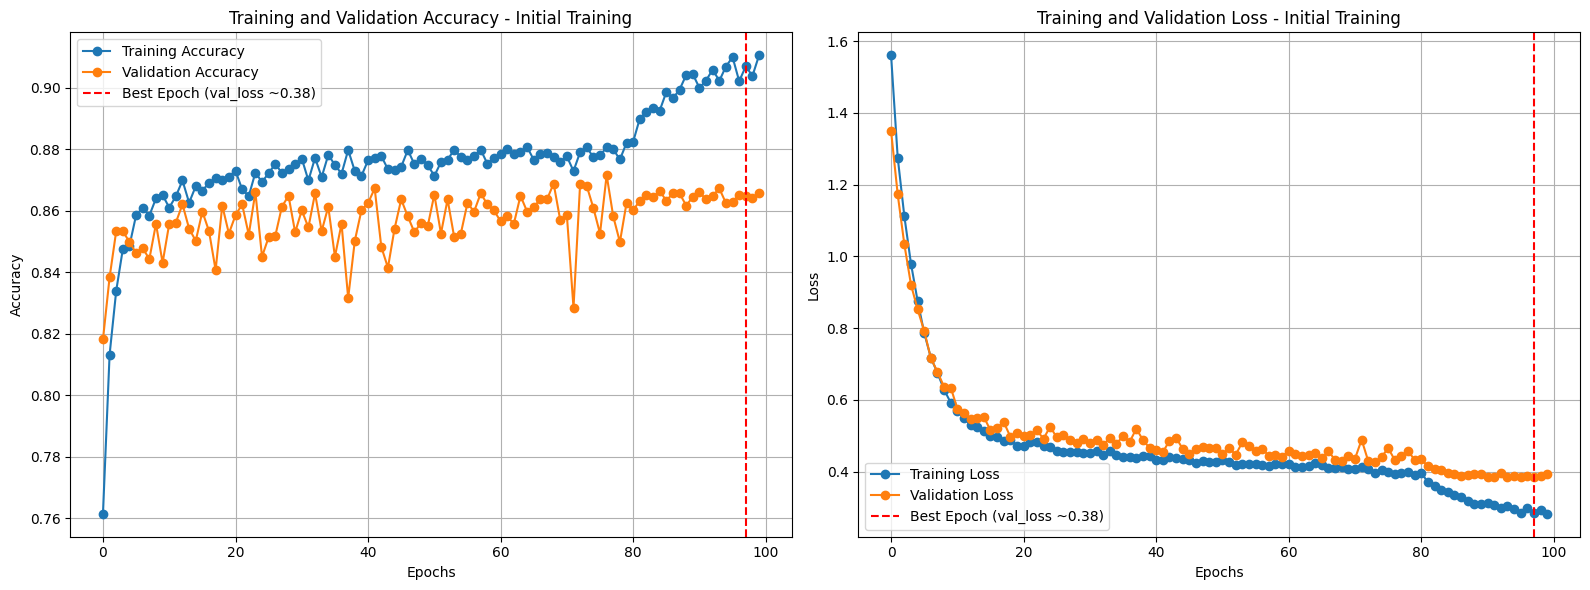

In [46]:
#STEP 9 show tranining results!
def plot_training_history(history_obj, title_suffix=' - Initial Training'):

    if history_obj is None or not hasattr(history_obj, 'history'):
        print("No training history object found to plot.")
        return

    history_dict = history_obj.history

    acc = history_dict.get('accuracy')
    val_acc = history_dict.get('val_accuracy')
    loss = history_dict.get('loss')
    val_loss = history_dict.get('val_loss')

    # التحقق من وجود كل المقاييس المطلوبة
    if acc is None or val_acc is None or loss is None or val_loss is None:
        print("History object is missing one or more required metrics (accuracy, val_accuracy, loss, val_loss).")
        print(f"Available keys in history: {list(history_dict.keys())}")
        return

    # تحديد عدد الحقب التي تم التدريب عليها فعليًا
    # قد يكون أقل من EPOCHS إذا تم تفعيل EarlyStopping
    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 6))

    # الرسم البياني للدقة
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o', linestyle='-')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o', linestyle='-')
    plt.axvline(x=early_stopping_callback.best_epoch if hasattr(early_stopping_callback, 'best_epoch') and early_stopping_callback.best_epoch is not None else (early_stopping_callback.stopped_epoch - early_stopping_callback.patience if early_stopping_callback.stopped_epoch > 0 else -1) , color='r', linestyle='--', label=f'Best Epoch (val_loss ~{early_stopping_callback.best:.2f})')
    plt.legend(loc='best') # 'best' لتحديد أفضل موقع تلقائيًا
    plt.title(f'Training and Validation Accuracy{title_suffix}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True) # إضافة شبكة لتسهيل القراءة

    # الرسم البياني للخسارة
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o', linestyle='-')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', linestyle='-')
    plt.axvline(x=early_stopping_callback.best_epoch if hasattr(early_stopping_callback, 'best_epoch') and early_stopping_callback.best_epoch is not None else (early_stopping_callback.stopped_epoch - early_stopping_callback.patience if early_stopping_callback.stopped_epoch > 0 else -1), color='r', linestyle='--', label=f'Best Epoch (val_loss ~{early_stopping_callback.best:.2f})')
    plt.legend(loc='best')
    plt.title(f'Training and Validation Loss{title_suffix}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout() #
    plt.show()

if 'history' in globals() and history is not None:
    print("Plotting training history...")
    plot_training_history(history)
else:
    print("Skipping history plot as 'history' object was not found (training might have failed or been skipped).")

Attempting to load best dual-input model from: /content/model_checkpoints_dual_input/best_dual_input_model_epoch_19_valloss_0.4970.keras
Best dual-input model loaded successfully for evaluation.

Evaluating the loaded best model on the validation data...
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8393 - auc: 0.4031 - loss: 0.5074 - precision: 0.2544 - recall: 0.3931

--- Validation Metrics (from loaded best model) ---
loss: 0.4970
compile_metrics: 0.8617

Generating predictions for classification report and confusion matrix...
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step

Shape of y_true (actual labels): (2524,), Unique values & counts: (array([0, 1]), array([1499, 1025]))
Shape of y_pred (predicted labels): (2524,), Unique values & counts: (array([0, 1]), array([1368, 1156]))

--- Classification Report (for loaded best model) ---
              precision    recall  f1-score   support

   authentic     0.9203    0.8399    0.8783      1499
      forged     0.7924    0.8937    0.84

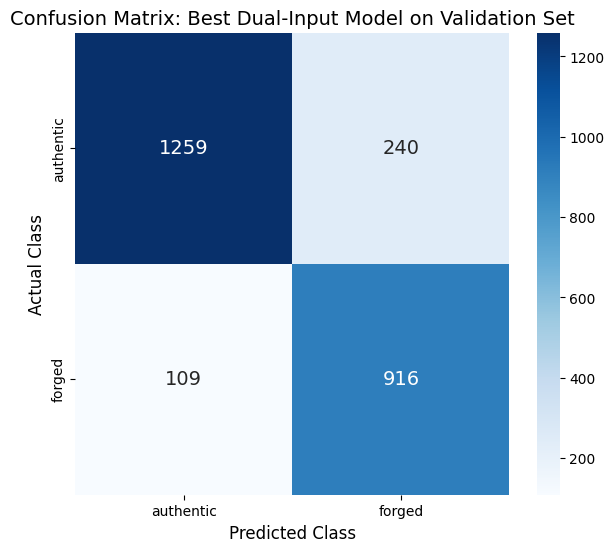


Overall F1 Score (Macro): 0.8591
Overall F1 Score (Micro - often same as accuracy for binary): 0.8617
Overall F1 Score (Weighted): 0.8627


In [65]:
# STEP 10, evaluate the model on validation..
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

if ('checkpoint_filepath' in globals() and checkpoint_filepath is not None and
    'validation_dataset' in globals() and validation_dataset is not None and
    'CLASS_NAMES' in globals() and CLASS_NAMES is not None): # CLASS_NAMES from Cell 4
    model_path = checkpoint_filepath.format(epoch = 19, val_loss = 0.4970) # edit this with the latest saved model.
    print(f"Attempting to load best dual-input model from: {model_path}")
    best_model_to_evaluate = None
    try:
        # No custom_objects needed if all layers are standard Keras layers
        best_model_to_evaluate = tf.keras.models.load_model(model_path)
        print("Best dual-input model loaded successfully for evaluation.")
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        print("Please ensure that the path is correct and the model was saved properly.")
        print("If 'EarlyStopping' with 'restore_best_weights=True' was used, the 'model' variable in memory might be the best version.")

    if best_model_to_evaluate:
        print("\nEvaluating the loaded best model on the validation data...")
        # The validation_dataset yields ((rgb, ela), labels), which matches the dual-input model
        results = best_model_to_evaluate.evaluate(validation_dataset, verbose=1)

        print("\n--- Validation Metrics (from loaded best model) ---")
        if hasattr(best_model_to_evaluate, 'metrics_names'):
            for name, value in zip(best_model_to_evaluate.metrics_names, results):
                print(f"{name}: {value:.4f}")
        else:
            # Fallback if metrics_names is not available (should be for compiled models)
            print(f"Loss: {results[0]:.4f}")
            if len(results) > 1: print(f"Accuracy: {results[1]:.4f}")


        print("\nGenerating predictions for classification report and confusion matrix...")
        # Get predictions as probabilities
        y_pred_proba = best_model_to_evaluate.predict(validation_dataset)
        # Convert probabilities to class labels (0 or 1) based on a 0.5 threshold
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()

        # Get true labels from the validation dataset
        y_true = []
        # validation_dataset yields ((rgb_batch, ela_batch), labels_batch)
        for inputs_batch, labels_batch in validation_dataset:
            y_true.extend(labels_batch.numpy().flatten().astype(int))
        y_true = np.array(y_true)

        print(f"\nShape of y_true (actual labels): {y_true.shape}, Unique values & counts: {np.unique(y_true, return_counts=True)}")
        print(f"Shape of y_pred (predicted labels): {y_pred.shape}, Unique values & counts: {np.unique(y_pred, return_counts=True)}")

        if y_true.shape == y_pred.shape and len(y_true) > 0:
            print("\n--- Classification Report (for loaded best model) ---")
            # CLASS_NAMES should be ['authentic', 'forged'] (or similar) from Cell 4
            print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

            print("\n--- Confusion Matrix (for loaded best model) ---")
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(7, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
                        annot_kws={"size": 14})
            plt.title('Confusion Matrix: Best Dual-Input Model on Validation Set', fontsize=14)
            plt.ylabel('Actual Class', fontsize=12)
            plt.xlabel('Predicted Class', fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.show()

            f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
            f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
            f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
            print(f"\nOverall F1 Score (Macro): {f1_macro:.4f}")
            print(f"Overall F1 Score (Micro - often same as accuracy for binary): {f1_micro:.4f}")
            print(f"Overall F1 Score (Weighted): {f1_weighted:.4f}")
        else:
            print("\nCould not generate classification report or confusion matrix due to label/prediction mismatch or empty data.")
            print(f"Length of y_true: {len(y_true)}, Length of y_pred: {len(y_pred)}")
    else:
        print("\nBest model not loaded. Skipping final evaluation steps.")
else:
    print("\nSkipping evaluation: One or more required variables are not defined or are None.")
    print("Required: 'checkpoint_filepath' (must be the path to the actual .keras file), 'validation_dataset', 'CLASS_NAMES'.")


--- Careful Fine-Tuning Stage 1: Preparation (Minimal Unfreezing) ---
Loading model for Careful Fine-Tuning Stage 1 from: /content/model_checkpoints_dual_input_robust_head/best_dual_model_robust_head.keras
Model from robust head training loaded successfully.

Carefully unfreezing layers in 'resnet50v2_rgb_base' containing 'conv5_block3':
Finished setting trainability for resnet50v2_rgb_base. Unfroze 11 layers/sub-layers.

Carefully unfreezing layers in 'resnet50v2_ela_base' containing 'conv5_block3':
Finished setting trainability for resnet50v2_ela_base. Unfroze 11 layers/sub-layers.
Total trainable parameters after careful partial unfreezing (Stage 1): 11160065
Partial unfreezing of top blocks in base models complete.

Using AdamW optimizer with learning rate: 5e-06 for Careful FT Stage 1.
Model re-compiled for Careful Fine-Tuning Stage 1.

--- Model Summary (Careful FT Stage 1, Minimal Unfreeze) ---


Model: "RobustDualInputHeadModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgb_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_strong_augment… │ (None, 224, 224,  │          0 │ rgb_input[0][0]   │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ela_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_3       │ (None, 224, 224,  │          0 │ rgb_strong_augme… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ela_augmentation    │ (None, 224, 224,  │          0 │ ela_input[0][0]   │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_3          │ (None, 224, 224,  │          0 │ true_divide_3[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ela_rescaling       │ (None, 224, 224,  │          0 │ ela_augmentation… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2_rgb_base │ (None, 2048)      │ 23,564,800 │ subtract_3[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2_ela_base │ (None, 2048)      │ 23,564,800 │ ela_rescaling[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenated_featu… │ (None, 4096)      │          0 │ resnet50v2_rgb_b… │
│ (Concatenate)       │                   │            │ resnet50v2_ela_b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_intermediate… │ (None, 512)       │  2,097,664 │ concatenated_fea… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_interme… │ (None, 512)       │      2,048 │ dense_intermedia… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_intermedia… │ (None, 512)       │          0 │ batch_norm_inter… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_intermediate… │ (None, 256)       │    131,328 │ dropout_intermed… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_interme… │ (None, 256)       │      1,024 │ dense_intermedia… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_intermedia… │ (None, 256)       │          0 │ batch_norm_inter… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 1)         │        257 │ dropout_intermed

 Total params: 49,361,921 (188.30 MB)

 Trainable params: 11,160,065 (42.57 MB)

 Non-trainable params: 38,201,856 (145.73 MB)

---------------------------------------------------------------

Using existing class weights from robust head training: {0: 0.8419559412550066, 1: 1.231088335773548}

Callbacks prepared for Careful FT Stage 1. Monitoring 'val_loss'. Best model saved to /content/model_checkpoints_dual_careful_ft_s1/best_model_dual_careful_FT_S1.keras

--- Starting Careful Fine-tuning Stage 1 Process (Minimal Unfreeze) ---
Epoch 1/30
315/316 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8562 - auc: 0.9403 - loss: 0.4209 - precision: 0.7774 - recall: 0.9228
Epoch 1: val_loss improved from inf to 0.42737, saving model to /content/model_checkpoints_dual_careful_ft_s1/best_model_dual_careful_FT_S1.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 53s 103ms/step - accuracy: 0.8562 - auc: 0.9403 - loss: 0.4209 - precision: 0.7774 - recall: 0.9228 - val_accuracy: 0.8601 - val_auc: 0.9327 - val_loss: 0.4274 - val_precision: 0.7828 - val_recall: 0.9073 - learning_rate: 5.0000e-06
Epoch 2/30
315/316 ━━━━━━━━━━━━━━━━━━━━ 0s 70

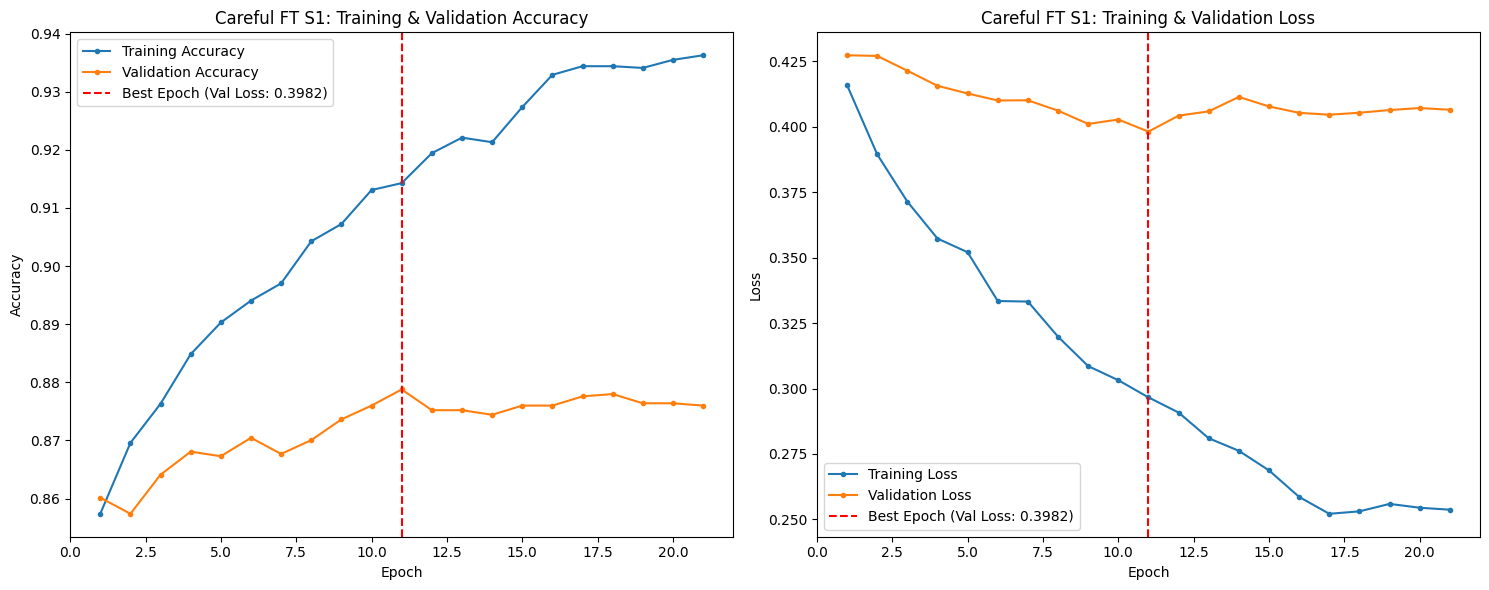


--- Evaluating Best Model from Careful Fine-tuning Stage 1 ---
Loading best model from Careful FT Stage 1: /content/model_checkpoints_dual_careful_ft_s1/best_model_dual_careful_FT_S1.keras

Evaluating the best model from Careful FT Stage 1 on validation data...
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.8547 - auc: 0.4047 - loss: 0.4058 - precision: 0.2606 - recall: 0.4006

--- Validation Metrics (from best model of Careful FT Stage 1) ---
loss: 0.3982
compile_metrics: 0.8788

(To get detailed classification report and CM, adapt evaluation code from previous fine-tuning cell using 'final_best_model_careful_s1')


In [88]:
# FINE TUNING STEP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Careful Fine-Tuning Stage 1: Preparation (Minimal Unfreezing) ---")

MODEL_PATH_ROBUST_HEAD = '/content/model_checkpoints_dual_input_robust_head/best_dual_model_robust_head.keras'

if not os.path.exists(MODEL_PATH_ROBUST_HEAD):
    print(f"ERROR: Model checkpoint file from robust head training not found at {MODEL_PATH_ROBUST_HEAD}")
    careful_ft_model_s1 = None
else:
    print(f"Loading model for Careful Fine-Tuning Stage 1 from: {MODEL_PATH_ROBUST_HEAD}")
    try:
        careful_ft_model_s1 = tf.keras.models.load_model(MODEL_PATH_ROBUST_HEAD)
        print("Model from robust head training loaded successfully.")
    except Exception as e:
        print(f"Error loading model: {e}")
        careful_ft_model_s1 = None

if careful_ft_model_s1:
    # 2. Ultra-Conservative Partial Unfreezing of Base Model Layers
    # We will unfreeze only the very last block (e.g., conv5_block3) of each ResNet base.
    try:
        base_model_rgb = careful_ft_model_s1.get_layer('resnet50v2_rgb_base')
        base_model_ela = careful_ft_model_s1.get_layer('resnet50v2_ela_base')

        # IMPORTANT: Ensure base models are initially treated as non-trainable
        # This is mostly for clarity as we selectively unfreeze. The head is already trainable.
        base_model_rgb.trainable = False
        base_model_ela.trainable = False

        # Unfreeze only layers within the 'conv5_block3' (the very last block of ResNet50V2)
        # You can be even more conservative by targeting fewer layers or specific layer names.
        layers_to_unfreeze_suffix_rgb = 'conv5_block3' # Target layers containing this in their name
        layers_to_unfreeze_suffix_ela = 'conv5_block3' # Target layers containing this in their name

        print(f"\nCarefully unfreezing layers in '{base_model_rgb.name}' containing '{layers_to_unfreeze_suffix_rgb}':")
        unfrozen_rgb_count = 0
        for layer in base_model_rgb.layers:
            if layers_to_unfreeze_suffix_rgb in layer.name: # Example: 'conv5_block3_1_conv', 'conv5_block3_2_bn', etc.
                layer.trainable = True
                unfrozen_rgb_count +=1
            else:
                layer.trainable = False # Ensure other base layers remain frozen
        print(f"Finished setting trainability for {base_model_rgb.name}. Unfroze {unfrozen_rgb_count} layers/sub-layers.")

        print(f"\nCarefully unfreezing layers in '{base_model_ela.name}' containing '{layers_to_unfreeze_suffix_ela}':")
        unfrozen_ela_count = 0
        for layer in base_model_ela.layers:
            if layers_to_unfreeze_suffix_ela in layer.name:
                layer.trainable = True
                unfrozen_ela_count +=1
            else:
                layer.trainable = False # Ensure other base layers remain frozen
        print(f"Finished setting trainability for {base_model_ela.name}. Unfroze {unfrozen_ela_count} layers/sub-layers.")

        trainable_params_careful_s1 = np.sum([np.prod(list(v.shape)) for v in careful_ft_model_s1.trainable_variables])
        print(f"Total trainable parameters after careful partial unfreezing (Stage 1): {trainable_params_careful_s1}")

        # Check if any base model layers actually became trainable
        if unfrozen_rgb_count == 0 and unfrozen_ela_count == 0:
            print("WARNING: No layers in the base models seem to have been unfrozen. Check patterns and layer names.")
        else:
            print("Partial unfreezing of top blocks in base models complete.")

    except ValueError as e:
        print(f"ERROR: Could not find base model layers. Error: {e}")
        careful_ft_model_s1 = None

if careful_ft_model_s1:
    # 3. Re-compile the Model with a Very, Very Low Learning Rate
    # Start extremely low for these newly unfrozen layers.
    learning_rate_careful_s1_ft = 5e-6 # e.g., 0.000005 or even 1e-6
    optimizer_careful_s1_ft = tf.keras.optimizers.AdamW( # Using AdamW as in robust head training
        learning_rate=learning_rate_careful_s1_ft,
        weight_decay=1e-5 # Can use a small weight decay
    )
    print(f"\nUsing AdamW optimizer with learning rate: {learning_rate_careful_s1_ft} for Careful FT Stage 1.")

    # Assuming loss_function and metrics are still defined from robust head training (Cell 6)
    if 'loss_function' not in globals() or 'metrics' not in globals():
        print("Re-defining loss_function and metrics.")
        loss_function = tf.keras.losses.BinaryCrossentropy()
        metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]

    careful_ft_model_s1.compile(
        optimizer=optimizer_careful_s1_ft,
        loss=loss_function,
        metrics=metrics
    )
    print("Model re-compiled for Careful Fine-Tuning Stage 1.")
    print("\n--- Model Summary (Careful FT Stage 1, Minimal Unfreeze) ---")
    careful_ft_model_s1.summary() # Verify trainable params count
    print("---------------------------------------------------------------\n")

    # 4. Class Weights (should be the same as used in robust head training - Cell 8)
    if 'class_weights_rh' in globals() and class_weights_rh is not None:
        print(f"Using existing class weights from robust head training: {class_weights_rh}")
        class_weights_to_use = class_weights_rh
    else:
        print("WARNING: Class weights 'class_weights_rh' not found. Recalculating or proceeding without.")
        # Simplified recalculation (ensure RGB_TRAIN_DIR and CLASS_NAMES are available)
        if 'RGB_TRAIN_DIR' in globals() and 'CLASS_NAMES' in globals():
            path_class_0 = os.path.join(RGB_TRAIN_DIR, CLASS_NAMES[0])
            path_class_1 = os.path.join(RGB_TRAIN_DIR, CLASS_NAMES[1])
            num_class_0_train = len([name for name in os.listdir(path_class_0) if os.path.isfile(os.path.join(path_class_0, name))]) if os.path.exists(path_class_0) else 0
            num_class_1_train = len([name for name in os.listdir(path_class_1) if os.path.isfile(os.path.join(path_class_1, name))]) if os.path.exists(path_class_1) else 0
            total_train_samples = num_class_0_train + num_class_1_train
            if total_train_samples > 0 and num_class_0_train > 0 and num_class_1_train > 0:
                weight_for_0 = (1 / num_class_0_train) * (total_train_samples / 2.0)
                weight_for_1 = (1 / num_class_1_train) * (total_train_samples / 2.0)
                class_weights_to_use = {0: weight_for_0, 1: weight_for_1}
                print(f"Recalculated class weights: {class_weights_to_use}")
            else: class_weights_to_use = None
        else: class_weights_to_use = None
        if class_weights_to_use is None: print("Proceeding without class weights.")


    # 5. Setup New Callbacks for Careful Fine-tuning Stage 1
    # checkpoint_dir_robust_head was '/content/model_checkpoints_dual_input_robust_head/'
    # Let's save to a new sub-directory or with a new naming scheme
    careful_ft_s1_checkpoint_dir = '/content/model_checkpoints_dual_careful_ft_s1/'
    os.makedirs(careful_ft_s1_checkpoint_dir, exist_ok=True)
    careful_ft_s1_checkpoint_filepath = os.path.join(careful_ft_s1_checkpoint_dir, 'best_model_dual_careful_FT_S1.keras')

    careful_ft_s1_mc_monitor = 'val_loss' # Monitor val_loss
    careful_ft_s1_mc_mode = 'min'

    careful_ft_s1_model_checkpoint = ModelCheckpoint(
        filepath=careful_ft_s1_checkpoint_filepath,
        monitor=careful_ft_s1_mc_monitor,
        mode=careful_ft_s1_mc_mode,
        save_best_only=True, # Save only the best
        verbose=1
    )

    careful_ft_s1_es_patience = 10 # Can be moderate; training should be slow and stable
    careful_ft_s1_early_stopping = EarlyStopping(
        monitor=careful_ft_s1_mc_monitor, # Monitor the same as checkpoint
        patience=careful_ft_s1_es_patience,
        mode=careful_ft_s1_mc_mode,
        verbose=1,
        restore_best_weights=True # Crucial
    )

    careful_ft_s1_rlr_patience = 4
    careful_ft_s1_reduce_lr = ReduceLROnPlateau(
        monitor=careful_ft_s1_mc_monitor,
        factor=0.2, # Reduce significantly if plateaued
        patience=careful_ft_s1_rlr_patience,
        verbose=1,
        min_lr=1e-7 # Allow LR to go very low
    )

    careful_ft_s1_callbacks_list = [
        careful_ft_s1_model_checkpoint,
        careful_ft_s1_early_stopping,
        careful_ft_s1_reduce_lr
    ]
    print(f"\nCallbacks prepared for Careful FT Stage 1. Monitoring '{careful_ft_s1_mc_monitor}'. Best model saved to {careful_ft_s1_checkpoint_filepath}")

    # 6. Start Careful Fine-tuning Stage 1 Process
    print("\n--- Starting Careful Fine-tuning Stage 1 Process (Minimal Unfreeze) ---")
    # Max epochs for this stage; EarlyStopping will likely stop it sooner if no improvement
    # With very few unfrozen layers and low LR, it might need a fair number of epochs to show change
    careful_ft_s1_epochs = 30

    # Ensure datasets are available (should be from Cell 4)
    if ('train_dataset' in globals() and train_dataset is not None and
        'validation_dataset' in globals() and validation_dataset is not None):

        history_careful_ft_s1 = careful_ft_model_s1.fit(
            train_dataset, # Combined dual-input dataset
            epochs=careful_ft_s1_epochs,
            validation_data=validation_dataset, # Combined dual-input validation dataset
            callbacks=careful_ft_s1_callbacks_list,
            class_weight=class_weights_to_use
        )

        print("\n----------------------------------------------------")
        print("      Careful Fine-tuning Stage 1 finished!         ")
        print("----------------------------------------------------")

        # 7. Plot Training History for Careful FT Stage 1
        if history_careful_ft_s1 is not None:
            # (Plotting code similar to previous fine-tuning cell, using history_careful_ft_s1)
            print("\n--- Plotting Careful Fine-tuning Stage 1 History ---")
            acc = history_careful_ft_s1.history['accuracy']
            val_acc = history_careful_ft_s1.history['val_accuracy']
            loss = history_careful_ft_s1.history['loss']
            val_loss = history_careful_ft_s1.history['val_loss']
            epochs_range = range(1, len(acc) + 1)
            best_epoch_val_loss = np.argmin(val_loss) + 1
            best_val_loss_value = np.min(val_loss)

            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.plot(epochs_range, acc, label='Training Accuracy', marker='.')
            plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='.')
            plt.axvline(x=best_epoch_val_loss, color='r', linestyle='--', label=f'Best Epoch (Val Loss: {best_val_loss_value:.4f})')
            plt.title('Careful FT S1: Training & Validation Accuracy')
            plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(loc='best')
            plt.subplot(1, 2, 2)
            plt.plot(epochs_range, loss, label='Training Loss', marker='.')
            plt.plot(epochs_range, val_loss, label='Validation Loss', marker='.')
            plt.axvline(x=best_epoch_val_loss, color='r', linestyle='--', label=f'Best Epoch (Val Loss: {best_val_loss_value:.4f})')
            plt.title('Careful FT S1: Training & Validation Loss')
            plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(loc='best')
            plt.tight_layout(); plt.show()
        else:
            print("No history object for Careful FT Stage 1 to plot.")


        # 8. Evaluate the Best Model from Careful Fine-tuning Stage 1
        print("\n--- Evaluating Best Model from Careful Fine-tuning Stage 1 ---")
        final_best_model_careful_s1 = None
        if os.path.exists(careful_ft_s1_checkpoint_filepath):
            print(f"Loading best model from Careful FT Stage 1: {careful_ft_s1_checkpoint_filepath}")
            final_best_model_careful_s1 = tf.keras.models.load_model(careful_ft_s1_checkpoint_filepath)
        elif careful_ft_s1_early_stopping.restore_best_weights and careful_ft_model_s1 is not None:
            print("Using model in memory (restored by EarlyStopping from Careful FT S1) as best model.")
            final_best_model_careful_s1 = careful_ft_model_s1
        else:
            print(f"ERROR: Best Careful FT S1 model checkpoint not found at {careful_ft_s1_checkpoint_filepath}.")

        if final_best_model_careful_s1:
            print("\nEvaluating the best model from Careful FT Stage 1 on validation data...")
            results_careful_ft_s1 = final_best_model_careful_s1.evaluate(validation_dataset, verbose=1)
            print("\n--- Validation Metrics (from best model of Careful FT Stage 1) ---")
            if hasattr(final_best_model_careful_s1, 'metrics_names'):
                for name, value in zip(final_best_model_careful_s1.metrics_names, results_careful_ft_s1):
                    print(f"{name}: {value:.4f}")

    else:
        print("ERROR: Datasets not defined. Cannot start Careful Fine-tuning Stage 1.")
else:
    print("ERROR: Model from robust head training was not loaded. Cannot start Careful Fine-tuning Stage 1.")

# **Fine tuning caused overfitting. so we will stop this attempt here. and use the head only trained model for the streamlit app!**

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [87]:
!cp -r /content/model_checkpoints_dual_input_robust_head/ /content/drive/MyDrive/model_checkpoints_dual_input_robust_head

✅ Model loaded.
              precision    recall  f1-score   support

         0.0       0.96      0.82      0.88      1499
         1.0       0.78      0.95      0.85      1025

    accuracy                           0.87      2524
   macro avg       0.87      0.88      0.87      2524
weighted avg       0.88      0.87      0.87      2524

🔍 Testing 10 images…

Au_pla_30050.jpg                →  AUTHENTIC  (p=0.0005)


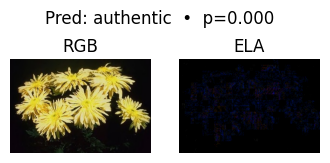

Au_ani_10001.jpg                →  FORGED     (p=0.5502)


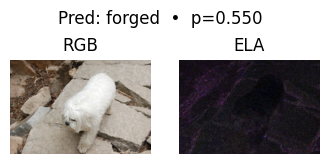

Au_ind_20012.jpg                →  FORGED     (p=0.8377)


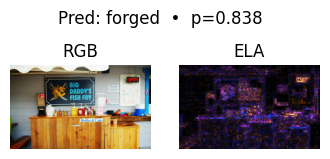

Au_cha_30513.jpg                →  AUTHENTIC  (p=0.0001)


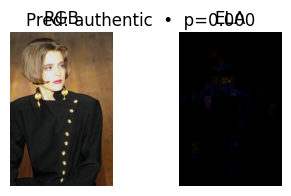

Au_nat_30208.jpg                →  AUTHENTIC  (p=0.0056)


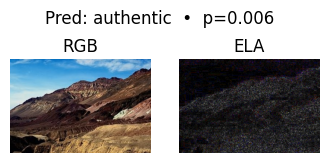

Tp_D_NRN_M_O_cha00094_cha00095_10046.png  →  FORGED     (p=0.9921)


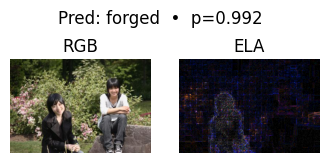

Tp_D_NRN_S_N_nat10115_cha00052_11477.jpg  →  AUTHENTIC  (p=0.1567)


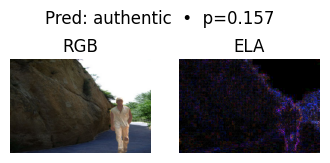

Tp_D_NRN_M_N_nat10126_cha00063_11652.jpg  →  FORGED     (p=0.7136)


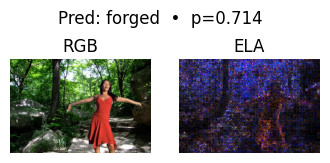

Tp_D_NRN_M_N_nat00002_nat00059_11513.jpg  →  AUTHENTIC  (p=0.2803)


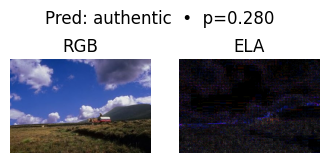

Tp_S_NRN_S_N_txt00070_txt00070_11315.jpg  →  FORGED     (p=0.7214)


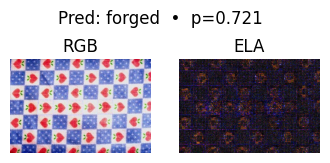

In [86]:
# ==================== CONFIGURATION ====================
MODEL_PATH = '/content/model_checkpoints_dual_input_robust_head/best_dual_model_robust_head.keras'
VAL_BASE_DIR = '/content/train_val_split_manual/validation'
IMG_SIZE = (224, 224)
ELA_QUALITY = 90
ELA_SCALE  = 15

# ==================== IMPORTS ==========================
import tensorflow as tf
from tensorflow import keras
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
import random, glob, os
import matplotlib.pyplot as plt

# ==================== LOAD MODEL =======================
model = keras.models.load_model(MODEL_PATH)
print("✅ Model loaded.")
y_true, y_pred = [], []

for (rgb, ela), label in validation_dataset:
    y_true.extend(label.numpy().flatten())
    preds = model.predict([rgb, ela], verbose=0).flatten()
    y_pred.extend((preds > 0.5).astype(int))

print(classification_report(y_true, y_pred))

# ==================== HELPERS ==========================
def generate_ela_image(pil_img, quality=90, scale=15):
    buf = tf.io.gfile.GFile(os.path.join('/tmp', 'tmp.jpg'), 'wb')
    pil_img.save(buf, 'JPEG', quality=quality)
    buf.close()
    resaved = Image.open(os.path.join('/tmp', 'tmp.jpg'))
    ela = ImageChops.difference(pil_img, resaved)
    ela = ImageEnhance.Brightness(ela).enhance(scale)
    return ela

def preprocess_rgb(pil_img):
    """Resize + ResNet-V2 preprocess (→ [-1,1])."""
    if pil_img.mode != "RGB":
        pil_img = pil_img.convert("RGB")
    pil_img = pil_img.resize(IMG_SIZE)
    arr = keras.preprocessing.image.img_to_array(pil_img)
    arr = tf.keras.applications.resnet_v2.preprocess_input(arr)
    return arr

def preprocess_ela(pil_img):
    """Resize ONLY; model contains Rescaling(1/255)."""
    if pil_img.mode != "RGB":
        pil_img = pil_img.convert("RGB")
    pil_img = pil_img.resize(IMG_SIZE)
    arr = keras.preprocessing.image.img_to_array(pil_img)  # values 0-255
    return arr

def predict_one(path):
    img = Image.open(path).convert('RGB')
    ela = generate_ela_image(img, quality=ELA_QUALITY, scale=ELA_SCALE)
    rgb_arr = preprocess_rgb(img)[None, ...]
    ela_arr = preprocess_ela(ela)[None, ...]
    proba = model.predict([rgb_arr, ela_arr], verbose=0)[0,0]
    return proba, img, ela

# ================== SAMPLE & PREDICT ===================
NUM_SAMPLES = 5
classes = ['authentic', 'forged']
samples = []

for cls in classes:
    folder = os.path.join(VAL_BASE_DIR, cls)
    files  = glob.glob(folder + '/*')
    samples += random.sample(files, min(NUM_SAMPLES, len(files)))

print(f"🔍 Testing {len(samples)} images…\n")

for path in samples:
    proba, rgb, ela = predict_one(path)
    label = 'forged' if proba > 0.5 else 'authentic'
    print(f"{os.path.basename(path):30s}  →  {label.upper():9s}  (p={proba:.4f})")

    # OPTIONAL: show images
    plt.figure(figsize=(4,2))
    plt.subplot(1,2,1); plt.imshow(rgb); plt.title('RGB'); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(ela); plt.title('ELA'); plt.axis('off')
    plt.suptitle(f"Pred: {label}  •  p={proba:.3f}")
    plt.show()

In [89]:
# ==============================================================
#   Batch-testing the first N forged validation images
#      using the correct dual-input preprocessing pipeline
# ==============================================================

import tensorflow as tf
from tensorflow import keras
import numpy as np, os, glob, random, hashlib
from PIL import Image
import matplotlib.pyplot as plt

# -------- CONFIGURATION ---------------------------------------
IMG_SIZE           = (224, 224)
N_IMAGES_TO_TEST   = 100
ELA_QUALITY        = 90
ELA_SCALE          = 15
# 1️⃣  Path to the model you really used during evaluation
BEST_MODEL_PATH = '/content/model_checkpoints_dual_input_robust_head/best_dual_model_robust_head.keras'

# 2️⃣  Validation folders
VAL_RGB_FORGED = '/content/train_val_split_manual/validation/forged'
VAL_ELA_FORGED = '/content/ela_dataset_prepared/validation/forged'

# --------- SAFETY CHECKS --------------------------------------
assert os.path.exists(BEST_MODEL_PATH), f"❌ Model not found at {BEST_MODEL_PATH}"
assert os.path.isdir(VAL_RGB_FORGED),   f"❌ RGB forged folder not found"
assert os.path.isdir(VAL_ELA_FORGED),   f"❌ ELA forged folder not found"

# --------- LOAD MODEL ----------------------------------------
model = keras.models.load_model(BEST_MODEL_PATH, compile=False)
print("✅ Model loaded:", BEST_MODEL_PATH)
print("🔑 MD5:", hashlib.md5(open(BEST_MODEL_PATH,'rb').read()).hexdigest())

# --------- HELPER FUNCTIONS ----------------------------------
def preprocess_rgb(pil_img):
    """Resize + ResNet-V2 preprocess (→ [-1,1])."""
    if pil_img.mode != "RGB":
        pil_img = pil_img.convert("RGB")
    pil_img = pil_img.resize(IMG_SIZE)
    arr = keras.preprocessing.image.img_to_array(pil_img)
    arr = tf.keras.applications.resnet_v2.preprocess_input(arr)
    return arr

def preprocess_ela(pil_img):
    """Resize ONLY; model contains Rescaling(1/255)."""
    if pil_img.mode != "RGB":
        pil_img = pil_img.convert("RGB")
    pil_img = pil_img.resize(IMG_SIZE)
    arr = keras.preprocessing.image.img_to_array(pil_img)  # values 0-255
    return arr

# --------- COLLECT SAMPLES -----------------------------------
rgb_files = sorted([f for f in os.listdir(VAL_RGB_FORGED)
                    if f.lower().endswith(('.png','.jpg','.jpeg','.bmp'))])

if not rgb_files:
    raise RuntimeError("🤔 No forged images found in validation folder")

sample_files = rgb_files[:N_IMAGES_TO_TEST]
print(f"🖼️  Testing {len(sample_files)} forged images …\n")

# --------- BATCH-TEST LOOP -----------------------------------
correct, wrong = 0, 0
for fname in sample_files:
    rgb_path = os.path.join(VAL_RGB_FORGED, fname)
    ela_path = os.path.join(VAL_ELA_FORGED, fname)

    if not os.path.exists(ela_path):
        continue

    # --- load & preprocess
    rgb_arr = preprocess_rgb(Image.open(rgb_path))[None, ...]
    ela_arr = preprocess_ela(Image.open(ela_path))[None, ...]
    proba   = model.predict([rgb_arr, ela_arr], verbose=0)[0,0]

    if proba > 0.5:
        correct += 1
        verdict = "FORGED ✅"
    else:
        wrong += 1
        verdict = "authentic ❌"
    print(f"{fname:35s}  p={proba:.3f}  →  {verdict}")

# --------- SUMMARY -------------------------------------------
tested = correct + wrong
print("\n📊  Summary")
print(f"Images tested        : {tested}")
print(f"Correctly ‘forged’   : {correct}  ({correct/tested*100:.2f} %)")
print(f"Mis-classified       : {wrong}  ({wrong/tested*100:.2f} %)")

✅ Model loaded: /content/model_checkpoints_dual_input_robust_head/best_dual_model_robust_head.keras
🔑 MD5: 0792bd712551e0c81145bd4ddb1a21a4
🖼️  Testing 100 forged images …

Tp_D_CNN_M_N_sec10110_sec10101_10298.png  p=0.699  →  FORGED ✅
Tp_D_CNN_M_N_txt00049_txt00050_10374.png  p=0.792  →  FORGED ✅
Tp_D_CNN_S_N_ind00005_ind00014_00424.png  p=0.873  →  FORGED ✅
Tp_D_CNN_S_N_txt00054_txt00049_10371.png  p=0.837  →  FORGED ✅
Tp_D_CRD_M_B_arc10113_arc10112_10030.png  p=0.689  →  FORGED ✅
Tp_D_CRD_M_B_sec00001_sec00003_10031.png  p=0.779  →  FORGED ✅
Tp_D_CRD_M_N_art00058_art00051_10534.png  p=0.844  →  FORGED ✅
Tp_D_CRD_M_N_txt00068_txt00065_10136.png  p=0.564  →  FORGED ✅
Tp_D_CRD_S_B_ani00071_ani00064_00191.png  p=0.970  →  FORGED ✅
Tp_D_CRD_S_N_ind00029_ind00088_00444.png  p=0.477  →  authentic ❌
Tp_D_CRN_M_N_ani00087_ani00081_10104.png  p=0.902  →  FORGED ✅
Tp_D_CRN_M_N_ani00097_ani00001_10099.png  p=0.987  →  FORGED ✅
Tp_D_CRN_M_N_nat00084_nat00095_10070.png  p=0.852  →  FORGED ✅
Tp_D_